# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.WARNING)
from IPython.display import display, clear_output

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
%config InlineBackend.figure_formats = ['png2x']

import pyaldata as pyal


try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    from mouse import defs as mouse_defs
    from monkey import defs as monkey_defs
    import params
    
    os.chdir(RepoPath / 'monkey')
    %run "_dataset-selection.ipynb"
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root
finally:
    os.chdir(nbPath)

if "__file__" not in dir():
    reload(dt)
    reload(mouse_defs)
    reload(monkey_defs)
    print('Done!')

the variable `GoodDataList` contains the session names
Done!


# reading data

In [2]:
animalList = ['mouse-data']

animalFiles = []
for animal in animalList:
    animalFiles.extend(utility.find_file(root/animal, 'mat'))


AllDFs=[]
for fname in animalFiles:
    print(fname)
    df = dt.load_pyal_data(fname)
    df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
    df['file'] = fname.split(os.sep)[-1]
    df = mouse_defs.prep_general_mouse(df)
    AllDFs.append(df)

clear_output()

In [3]:
warnings.filterwarnings("ignore")
allDFs_M1 = []
for animal, sessionList in GoodDataList[monkey_defs.areas[0]].items():
    if 'Mr' in animal:
        continue  # to remove MrT
    for session in sessionList:
        path = root/animal/session
        allDFs_M1.append(monkey_defs.prep_general(dt.load_pyal_data(path)))
        

allDFs_PMd = []
for animal, sessionList in GoodDataList[monkey_defs.areas[1]].items():
    if 'Mr' in animal:
        continue  # to remove MrT
    for session in sessionList:
        path = root/animal/session
        allDFs_PMd.append(monkey_defs.prep_general(dt.load_pyal_data(path)))
        
warnings.filterwarnings("default")

# Behavioural Correlations

Correlate behaviour during the trial  


## Correaltions to the **same** target, without time warping

trimming the trials to the same length

---

### mouse

In [4]:
def trim_within_mouse_corr(allDF:list[pd.DataFrame],):
    trim_within_corrs = {}
    within_good = within_bad = 0
    for df in allDF:
        trim_within_corrs[df.file[0]] = []
        targets = np.unique(df.target_id)
        for target in targets:
            df_ = pyal.select_trials(df, df.target_id == target)
            for i, vel1 in enumerate(df_.hVelB):
                a = vel1[df_.idx_movement_on[i]:df_.idx_pull_off[i],:]
                for j, vel2 in enumerate(df_.hVelB):
                    if j<=i: continue
                    b = vel2[df_.idx_movement_on[j]:df_.idx_pull_off[j],:]
                    if abs(len(b) - len(a)) > min((len(b) , len(a))):
                        within_bad += 1
                        continue
                    a_,b_ = mouse_defs.time_trim(a,b)
                    r = [pearsonr(aa,bb)[0] for aa,bb in zip(a_.T,b_.T)]
                    trim_within_corrs[df_.file[0]].append(np.mean(np.abs(r)))
                    within_good += 1

    logging.warning(f'mismatching within trial pair dropped: {within_bad/(within_good+within_bad)*100:2.0f}%')
    return trim_within_corrs


def trim_across_mouse_corr(allDF:list[pd.DataFrame],):
    trim_across_corrs = {}
    across_good = across_bad = 0
    for dfi, df1 in enumerate(allDF):
        targets = np.unique(df1.target_id)
        trim_across_corrs[df1.file[0]]={}
        for dfj, df2 in enumerate(allDF):
            trim_across_corrs[df2.file[0]] = {} if df2.file[0] not in trim_across_corrs.keys() else trim_across_corrs[df2.file[0]]
            if dfj <= dfi: continue
            trim_across_corrs[df1.file[0]][df2.file[0]]=[]
            for target in targets:
                df1_ = pyal.select_trials(df1, df1.target_id == target)
                df2_ = pyal.select_trials(df2, df2.target_id == target)
                for i, vel1 in enumerate(df1_.hVelB):
                    a = vel1[df1_.idx_movement_on[i]:df1_.idx_pull_off[i],:]
                    for j, vel2 in enumerate(df2_.hVelB):
                        b = vel2[df2_.idx_movement_on[j]:df2_.idx_pull_off[j],:]
                        if abs(len(b) - len(a)) > min((len(b) , len(a))):
                            across_bad += 1
                            continue
                        a_,b_ = mouse_defs.time_trim(a,b)
                        r = [pearsonr(aa,bb)[0] for aa,bb in zip(a_.T,b_.T)]
                        trim_across_corrs[df1_.file[0]][df2_.file[0]].append(np.mean(np.abs(r)))
                        across_good += 1

        # make the across correlations symmetrical!
        for  df2_file, val in trim_across_corrs[df1_.file[0]].items():
            trim_across_corrs[df2_file][df1_.file[0]] = val

    logging.warning(f'mismatching across trial pair dropped: {across_bad/(across_good+across_bad)*100:2.0f}%')
    return trim_across_corrs

---

### monkey

In [5]:
def trim_within_monkey_corr(allDF:list[pd.DataFrame],):
    good = bad = 0
    within_corrs = {}
    for df in allDF:
        within_corrs[df.session[0]] = []
        targets = np.unique(df.target_id)
        for target in targets:
            df_ = pyal.select_trials(df, df.target_id == target)
            for i, vel1 in enumerate(df_.vel):
                a = vel1[int(df_.idx_movement_on[i]):int(df_.idx_trial_end[i]),:]
                for j, vel2 in enumerate(df_.vel):
                    if j<=i: continue
                    b = vel2[int(df_.idx_movement_on[j]):int(df_.idx_trial_end[j]),:]
                    if abs(len(b) - len(a)) > min((len(b) , len(a))):
                        bad += 1
                        continue
                    a_,b_ = monkey_defs.time_trim(a,b)
                    r = [pearsonr(aa,bb)[0] for aa,bb in zip(a_.T,b_.T)]
                    within_corrs[df_.session[0]].append(np.mean(np.abs(r)))
                    good += 1
    
    logging.warning(f'mismatching across trial pair dropped: {bad/(good+bad)*100:2.0f}')
    return within_corrs


def trim_across_monkey_corr(allDF:list[pd.DataFrame],):
    good = bad = 0
    across_corrs = {}
    for dfi, df1 in enumerate(allDF):
        targets = np.unique(df1.target_id)
        across_corrs[df1.session[0]]={}
        for dfj, df2 in enumerate(allDF):
            across_corrs[df2.session[0]] = {} if df2.session[0] not in across_corrs.keys() else across_corrs[df2.session[0]]
            if dfj <= dfi: continue
            across_corrs[df1.session[0]][df2.session[0]]=[]
            for target in targets:
                df1_ = pyal.select_trials(df1, df1.target_id == target)
                df2_ = pyal.select_trials(df2, df2.target_id == target)
                for i, vel1 in enumerate(df1_.vel):
                    a = vel1[int(df1_.idx_movement_on[i]):int(df1_.idx_trial_end[i]),:]
                    for j, vel2 in enumerate(df2_.vel):
                        b = vel2[int(df2_.idx_movement_on[j]):int(df2_.idx_trial_end[j]),:]
                        if abs(len(b) - len(a)) > min((len(b) , len(a))):
                            bad += 1
                            continue
                        a_,b_ = monkey_defs.time_trim(a,b)
                        r = [pearsonr(aa,bb)[0] for aa,bb in zip(a_.T,b_.T)]
                        across_corrs[df1_.session[0]][df2_.session[0]].append(np.mean(np.abs(r)))
                        good += 1

        
        # make the across correlations symmetrical!
        for  df2_session, val in across_corrs[df1_.session[0]].items():
            across_corrs[df2_session][df1_.session[0]] = val

    logging.warning(f'mismatching across trial pair dropped: {bad/(good+bad)*100:2.0f}')
    return across_corrs

Calculate the correlations

In [6]:
if "__file__" not in dir():
    within_corrs_mice = trim_within_mouse_corr (AllDFs)
    across_corrs_mice = trim_across_mouse_corr (AllDFs)

    within_corrs_monkeys = trim_within_monkey_corr (allDFs_M1)
    across_corrs_monkeys = trim_across_monkey_corr (allDFs_M1)

Plot distribution of Behavioural correlations

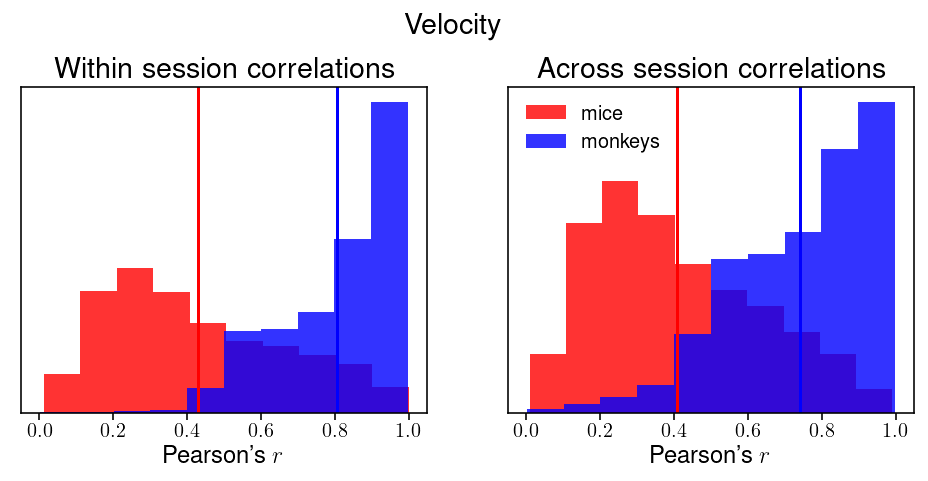

In [7]:
if "__file__" not in dir():     
    fig,axes = plt.subplots(1,2,figsize=(8,3), sharex=True)
    
    w_mice = list(within_corrs_mice.values())
    w_mice = np.array([l for L in w_mice for l in L])
    w_monkey = list(within_corrs_monkeys.values())
    w_monkey = np.array([l for L in w_monkey for l in L])
    axes[0].hist(w_mice,   density=True,alpha=.8,color='r',label=r'mice')
    axes[0].hist(w_monkey, density=True,alpha=.8,color='b',label=r'monkey')
    axes[0].axvline(w_mice.mean(), color='r')
    axes[0].axvline(w_monkey.mean(), color='b')
    axes[0].set_title('Within session correlations')

    a_mice = np.array([m for L in across_corrs_mice.values() for l in L.values() for m in l])
    a_monkey = np.array([m for L in across_corrs_monkeys.values() for l in L.values() for m in l])
    axes[1].hist(a_mice, density=True, alpha=.8,color='r',label=r'mice')
    axes[1].hist(a_monkey, density=True, alpha=.8,color='b',label=r'monkeys')
    axes[1].axvline(a_mice.mean(), color='r')
    axes[1].axvline(a_monkey.mean(), color='b')
    axes[1].set_title('Across session correlations')
    

    axes[1].legend()
#     axes[0].set_ylabel(r"");
    
    for ax in axes:
        ax.set_yticks([])
        ax.set_xlabel(r"Pearson's $r$");
    
    fig.suptitle('Velocity',fontsize='x-large', y=1.05);

# Canonical Correlations

mice

In [8]:
pairFileList_mice = []
for I, df1 in enumerate(AllDFs):
    for J, (df2) in enumerate(AllDFs):
        if J<=I or df1.file[0] == df2.file[0]: continue  # repetitions
        pairFileList_mice.append((I,J))


monkeys

In [9]:
pairFileList_monkeys = []
for I, df1 in enumerate(allDFs_M1):
    for J, df2 in enumerate(allDFs_M1):
        if J<=I or df1.session[0] == df2.session[0]: continue  # to repetitions
        pairFileList_monkeys.append((I,J))


read data

In [10]:
side1df = [AllDFs[i] for i,_ in pairFileList_mice]
side2df = [AllDFs[j] for _,j in pairFileList_mice]
warnings.filterwarnings("ignore")
AllData1_mice = dt.get_data_array(side1df, mouse_defs.exec_epoch, area=mouse_defs.areas[0], model=mouse_defs.n_components)
AllData2_mice = dt.get_data_array(side2df, mouse_defs.exec_epoch, area=mouse_defs.areas[0], model=mouse_defs.n_components)
_,_, min_trials_mice, min_time_mice,_ = np.min((AllData1_mice.shape,AllData2_mice.shape),axis=0)

side1df = [allDFs_M1[i] for i,_ in pairFileList_monkeys]
side2df = [allDFs_M1[j] for _,j in pairFileList_monkeys]
AllData1_monkey = dt.get_data_array(side1df, monkey_defs.exec_epoch, area=monkey_defs.areas[0], model=monkey_defs.n_components)
AllData2_monkey = dt.get_data_array(side2df, monkey_defs.exec_epoch, area=monkey_defs.areas[0], model=monkey_defs.n_components)
_,_, min_trials_monkey, min_time_monkey,_ = np.min((AllData1_monkey.shape,AllData2_monkey.shape),axis=0)

warnings.filterwarnings("default")


In [24]:
Behav_corr_TH = 0.4

CC_corr_mice=[]
for i, (sessionData1,sessionData2) in enumerate(zip(AllData1_mice,AllData2_mice)):
    data1 = np.reshape(sessionData1[:,:min_trials_mice,:min_time_mice,:], (-1,mouse_defs.n_components))
    data2 = np.reshape(sessionData2[:,:min_trials_mice,:min_time_mice,:], (-1,mouse_defs.n_components))
    k,l = pairFileList_mice[i]
    behav = np.array(across_corrs_mice[AllDFs[k].file[0]][AllDFs[l].file[0]])
    behav = behav[behav>Behav_corr_TH]
    CC_corr_mice.append((dt.canoncorr(data1, data2)[:4].mean() , np.mean(behav)))
CC_corr_mice = np.array(CC_corr_mice)


CC_corr_monkey=[]
for i, (sessionData1,sessionData2) in enumerate(zip(AllData1_monkey,AllData2_monkey)):
    data1 = np.reshape(sessionData1[:,:min_trials_monkey,:min_time_monkey,:], (-1,monkey_defs.n_components))
    data2 = np.reshape(sessionData2[:,:min_trials_monkey,:min_time_monkey,:], (-1,monkey_defs.n_components))
    k,l = pairFileList_monkeys[i]
    behav = np.array(across_corrs_monkeys[allDFs_M1[k].session[0]][allDFs_M1[l].session[0]])
    behav = behav[behav>Behav_corr_TH]
    CC_corr_monkey.append((dt.canoncorr(data1, data2)[:4].mean() , np.mean(behav)))
CC_corr_monkey = np.array(CC_corr_monkey)

plot

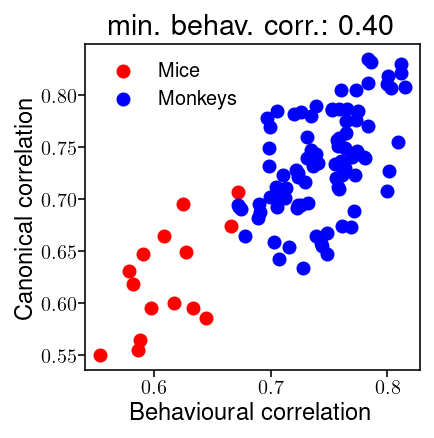

In [25]:
if "__file__" not in dir():     
    fig,ax = plt.subplots(1,1,figsize=(3,3),)
    
    ax.scatter(CC_corr_mice[:,1],CC_corr_mice[:,0],color='r', label='Mice')
    ax.scatter(CC_corr_monkey[:,1],CC_corr_monkey[:,0], color='b', label='Monkeys')

    ax.set_xlabel('Behavioural correlation')
    ax.set_ylabel('Canonical correlation')
    ax.legend()
    ax.set_title(f'min. behav. corr.: {Behav_corr_TH:0.2f}')